# Vulnerability Assessment

#### Intersecting hazard data with vital lands data

In [44]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

In [36]:
# Administrative boundaries
soco_bound = gpd.read_file("../data/clean/sonoma_county_boundary/sonoma_county_boundary.shp")

# read in VL data
croplands = gpd.read_file("../data/raw/Vital_Lands_Data_Package/VLI_Priority_Ag_Croplands.shp")
grazinglands = gpd.read_file("../data/raw/Vital_Lands_Data_Package/VLI_Priority_Ag_Grazing_Land.shp")

# read in hazard data
flood_plains = gpd.read_file("../data/clean/flood_awareness_areas/flood_awareness_areas.shp")
slr_75 = gpd.read_file("../data/clean/fldhazd_slr75_w000/all_fldhazd_slr75_w000.shp")
slr_75_100 = gpd.read_file("../data/clean/fldhazd_slr75_w100/all_fldhazd_slr75_w100.shp")
slr_200 = gpd.read_file("../data/clean/fldhazd_slr200_w000/all_fldhazd_slr200_w000.shp")
wildfire_risk = gpd.read_file("../data/clean/soco_wildfire_risk_index/Wildfire_Risk_Index.shp")

In [52]:
# Vital land EPSG:
grazinglands.crs

<Derived Projected CRS: EPSG:2226>
Name: NAD83 / California zone 2 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties of Alpine; Amador; Butte; Colusa; El Dorado; Glenn; Lake; Mendocino; Napa; Nevada; Placer; Sacramento; Sierra; Solano; Sonoma; Sutter; Yolo; Yuba.
- bounds: (-124.06, 38.02, -119.54, 40.16)
Coordinate Operation:
- name: SPCS83 California zone 2 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [3]:
# convert sonoma county boundary to vital lands 
soco_bound = soco_bound.to_crs(epsg=2226)

## Agriculture

Includes: Priority croplands and priority grazing land

In [4]:
# get grazing lands shapefile ready for combinations with croplands shapefile
grazinglands[["type"]] = "grazing_lands"
grazinglands_comb = grazinglands.drop(["Grazing_Ve", "Grazing__1", "OBJECTID"], axis=1)
grazinglands_comb = grazinglands_comb.rename(columns = {'LIFEFORM': 'MAP_CLASS'})
grazinglands_comb.head()

,MAP_CLASS,VLI_Priori,geometry,type
0,Herbaceous,Medium-High Priority,"POLYGON ((6261060.364 1891598.883, 6261067.724...",grazing_lands
1,Herbaceous,Medium-High Priority,"POLYGON ((6260406.459 1892204.227, 6260406.133...",grazing_lands
2,Herbaceous,Medium-High Priority,"POLYGON ((6259524.000 1892488.000, 6259546.000...",grazing_lands
3,Herbaceous,Medium-High Priority,"POLYGON ((6258542.026 1893045.930, 6258545.890...",grazing_lands
4,Herbaceous,Low Priority,"POLYGON ((6287838.000 1904024.000, 6287854.000...",grazing_lands


In [5]:
# get croplands ready for combination with grazing lands and combine
croplands[["type"]] = "croplands"
agriculture = pd.concat([croplands, grazinglands_comb])
agriculture.sample(10)

,MAP_CLASS,VLI_Priori,geometry,type
2105,Vineyard,Lower Priority,"POLYGON Z ((6349322.001 1886900.000 0.000, 634...",croplands
14418,Vineyard,Lower Priority,MULTIPOLYGON Z (((6328189.407 1885194.268 0.00...,croplands
4359,Vineyard,Lower Priority,MULTIPOLYGON Z (((6425457.433 1880159.305 0.00...,croplands
6895,Orchard or Grove,Higher Priority,"POLYGON Z ((6278218.000 2074340.439 0.000, 627...",croplands
1646,Vineyard,Lower Priority,"POLYGON Z ((6330048.000 1895695.257 0.000, 633...",croplands
13931,Herbaceous,Not a Priority,"POLYGON ((6339638.281 1885195.813, 6339529.605...",grazing_lands
16987,Vineyard,Lower Priority,"POLYGON Z ((6434929.352 1872037.879 0.000, 643...",croplands
18330,Vineyard,Lower Priority,"POLYGON Z ((6286883.350 2018965.914 0.000, 628...",croplands
22374,Vineyard,Lower Priority,"POLYGON Z ((6397984.000 1943664.288 0.000, 639...",croplands
13823,Herbaceous,Not a Priority,"MULTIPOLYGON (((6331741.634 1885822.366, 63317...",grazing_lands


In [49]:
# save file
agriculture.to_file("../data/clean/vulnerability_shps/agriculture/agriculture.shp") 

<AxesSubplot:>

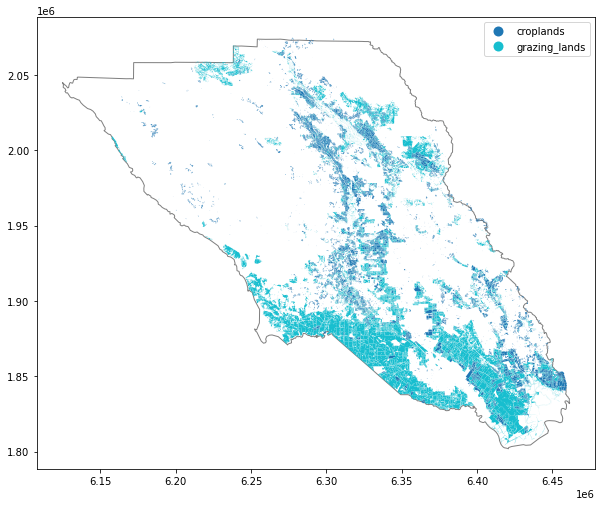

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
soco_bound.plot(ax=ax, edgecolor = "grey", color = "white")
agriculture.plot(ax=ax,column="type", legend=True)

In [38]:
# function to process intersections
def intersect_hazard(asset_layer, hazard_layer, epsg):
    hazard_crs = hazard_layer.to_crs(epsg=epsg)
    asset_hazard = gpd.overlay(asset_layer, hazard_crs, how='intersection')
    return asset_hazard

### Sea Level Rise

In [42]:
# 75 cm
ag_75_slr = intersect_hazard(agriculture, slr_75, 2226)
ag_75_slr.to_file("../data/clean/vulnerability_shps/agriculture/ag_75_slr.shp") 

# 75 cm + 100 yr flood
ag_75_slr_100 = intersect_hazard(agriculture, slr_75_100, 2226)
ag_75_slr_100.to_file("../data/clean/vulnerability_shps/agriculture/ag_75_slr_100.shp") 

# 200 cm
ag_200_slr = intersect_hazard(agriculture, slr_200, 2226)
ag_200_slr.to_file("../data/clean/vulnerability_shps/agriculture/ag_200_slr.shp") 


<AxesSubplot:>

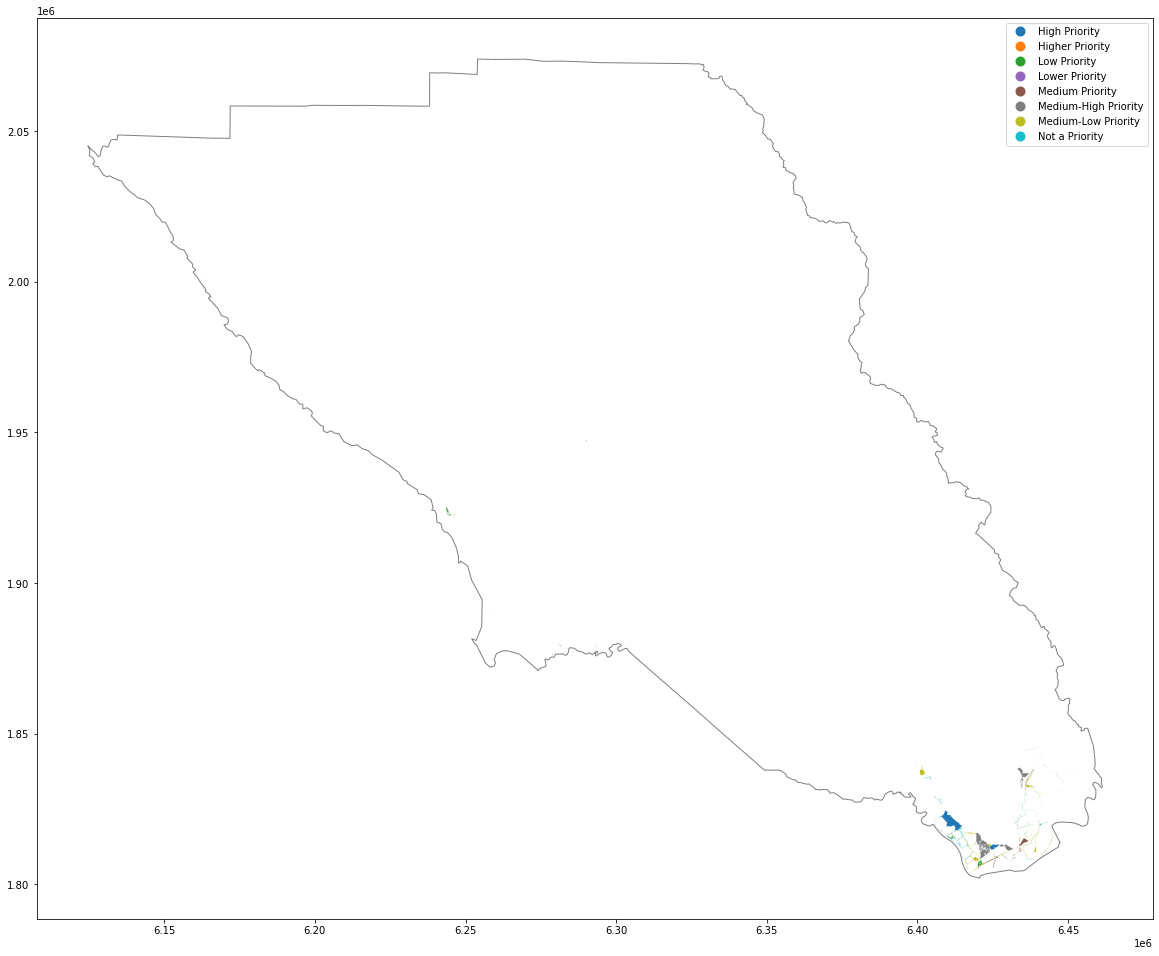

In [40]:
fig, ax = plt.subplots(figsize=(20,20))
soco_bound.plot(ax=ax, edgecolor = "grey", color = "white")
ag_75_slr.plot(ax=ax, column = "VLI_Priori", legend = True)

### Floodplains

In [59]:
flood_plains.head()

,OBJECTID,CLASS,Shape_Leng,Shape_Area,geometry
0,1,Channel,189.447583,5.508487e+02,"POLYGON Z ((6378504.646 1828395.109 0.000, 637..."
1,2,Channel,33127.224932,1.000599e+06,"POLYGON Z ((6420292.205 1831196.979 0.000, 642..."
2,3,Channel,180.511617,1.110010e+03,"POLYGON Z ((6370498.844 1831360.177 0.000, 637..."
3,4,Channel,147.956570,7.290920e+02,"POLYGON Z ((6419355.130 1831442.729 0.000, 641..."
4,5,Channel,833.234353,5.015419e+03,"POLYGON Z ((6363048.779 1833387.033 0.000, 636..."


In [8]:
# convert floodplains to vital lands crs
flood_plains = flood_plains.to_crs(epsg=2226)

# intersect floodplains with the grazing land file
# priority croplands were chosen outside of floodplains
agriculture_floodplain = gpd.overlay(grazinglands_comb, flood_plains, how='intersection')

In [9]:
# save the file
agriculture_floodplain.to_file("../data/clean/vulnerability_shps/agriculture/ag_floodplain.shp") 

<AxesSubplot:>

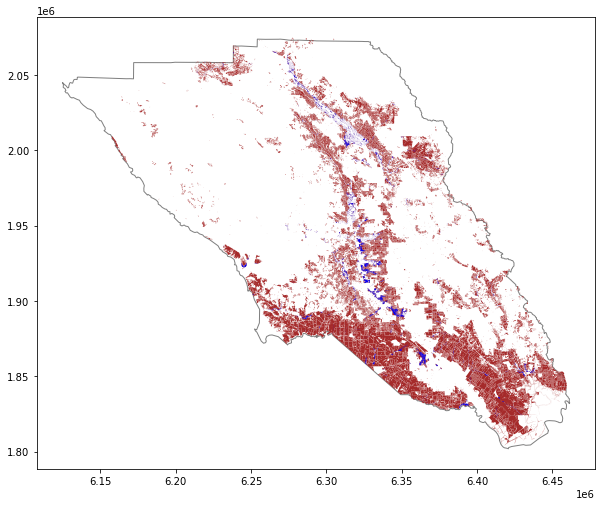

In [51]:
# agriculture in brown, flood plain ag in blue
fig, ax = plt.subplots(figsize=(10,10))
soco_bound.plot(ax=ax, edgecolor = "grey", color = "white")
agriculture.plot(ax=ax, color = "brown")
agriculture_floodplain.plot(ax=ax, color = "blue")

<AxesSubplot:>

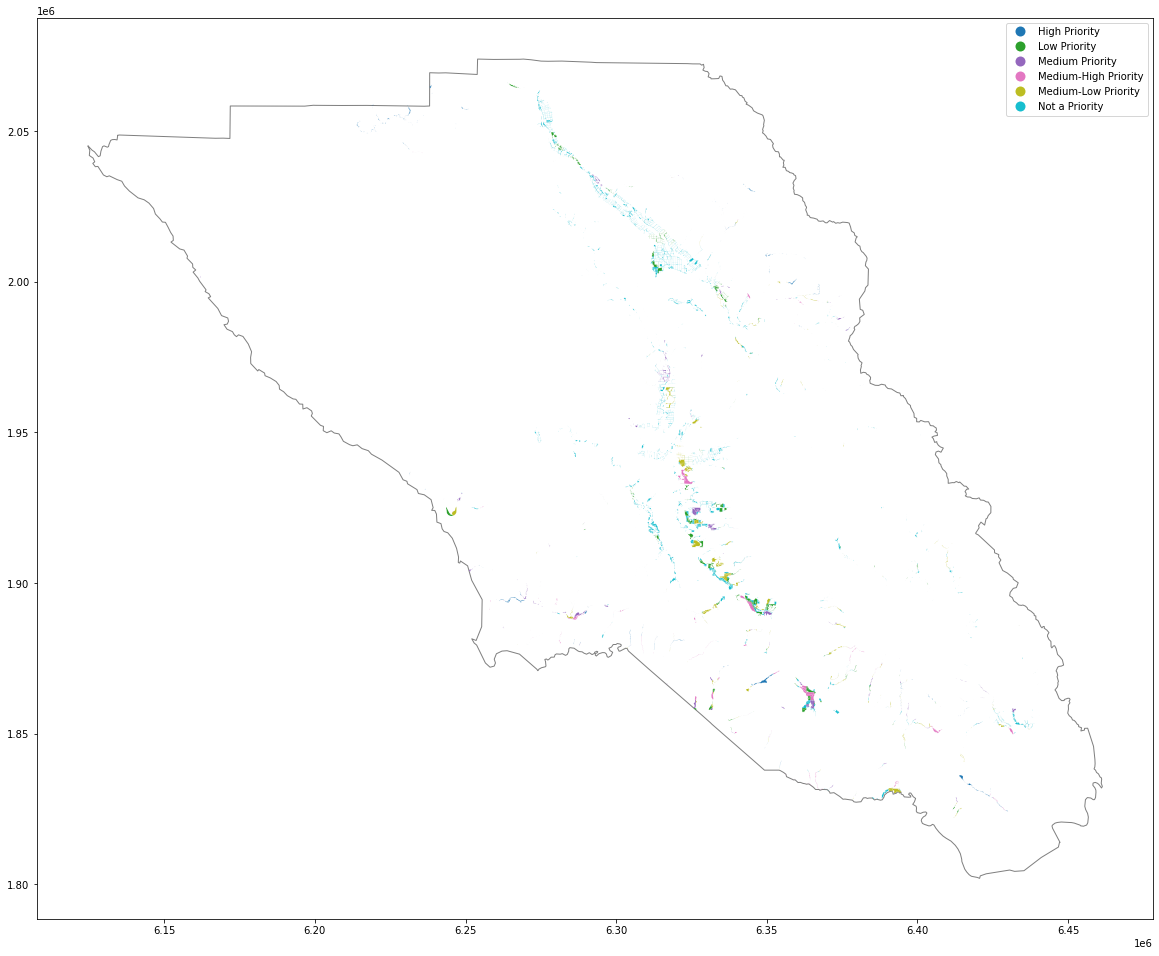

In [11]:
# flooded ag
fig, ax = plt.subplots(figsize=(20,20))
soco_bound.plot(ax=ax, edgecolor = "grey", color = "white")
agriculture_floodplain.plot(ax=ax, column = "VLI_Priori", legend = True)

In [18]:
# get the area of flooded agricultural land
agriculture_floodplain['area_ft2'] = agriculture_floodplain.area
agriculture_floodplain = agriculture_floodplain.drop(["Shape_Leng", "Shape_Area", "OBJECTID"], axis=1)
agriculture_floodplain

,MAP_CLASS,VLI_Priori,type,CLASS,geometry,area_ft2
0,Herbaceous,Not a Priority,grazing_lands,Unknown Riparian,"POLYGON Z ((6287018.000 1908802.000 0.000, 628...",14563.288803
1,Herbaceous,Medium Priority,grazing_lands,Unknown Riparian,MULTIPOLYGON Z (((6277940.000 1912220.000 0.00...,47864.527624
2,Herbaceous,Medium-Low Priority,grazing_lands,Unknown Riparian,MULTIPOLYGON Z (((6274314.000 1910584.000 0.00...,2353.406401
3,Herbaceous,Medium-Low Priority,grazing_lands,Unknown Riparian,MULTIPOLYGON Z (((6273516.000 1910112.000 0.00...,15299.427146
4,Herbaceous,Medium-Low Priority,grazing_lands,Unknown Riparian,"POLYGON Z ((6273812.000 1910368.000 0.000, 627...",8239.872482
...,...,...,...,...,...,...
3961,Herbaceous,Not a Priority,grazing_lands,Unknown Riparian,MULTIPOLYGON Z (((6328097.371 2011434.298 0.00...,47147.896774
3962,Herbaceous,Medium-Low Priority,grazing_lands,Unknown Riparian,MULTIPOLYGON Z (((6328508.000 2015150.000 0.00...,70926.308433
3963,Herbaceous,Not a Priority,grazing_lands,Unknown Riparian,MULTIPOLYGON Z (((6328281.395 2011111.543 0.00...,2002.574366
3964,Herbaceous,High Priority,grazing_lands,Floodplain,"POLYGON Z ((6349788.000 2008682.000 0.000, 634...",41006.400657


In [20]:
# Vital lands took out floodplains from priority croplands so we should just be looking at grazing lands that are in floodplains
grazing_floodplain = agriculture_floodplain.groupby(['VLI_Priori']).sum('area_ft2')
grazing_floodplain["percent_floodplain"] = grazing_floodplain["area_ft2"]/grazinglands.dissolve(by="VLI_Priori", aggfunc='sum').area

In [21]:
grazing_floodplain["percent_floodplain"] *= 100

Text(0, 0.5, 'Percent (%)')

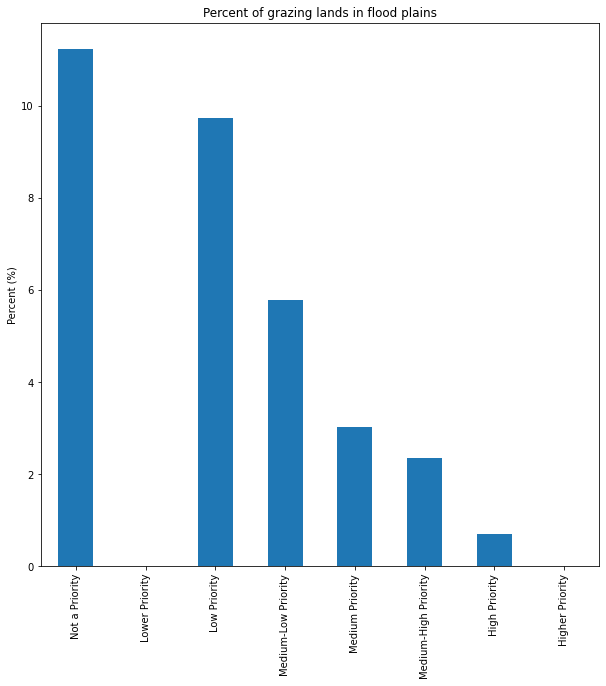

In [22]:
# plot grouped bar chart
order = [
"Not a Priority",
"Lower Priority",
"Low Priority",
"Medium-Low Priority",
"Medium Priority",
"Medium-High Priority",
"High Priority",
"Higher Priority"
]
grazing_floodplain = grazing_floodplain.reindex(order)
ax = grazing_floodplain.plot(
        y = "percent_floodplain",
        kind='bar',
        stacked=False,
        title='Percent of grazing lands in flood plains',
        legend = False,
        figsize=(10, 10))
ax.set_xlabel("")
ax.set_ylabel("Percent (%)")

### Wildfire Risk

In [24]:
# intersect wildfire risk and agricultural land
wildfire_risk = wildfire_risk.to_crs(epsg=2226)

ag_fire_risk = gpd.overlay(agriculture, wildfire_risk, how='intersection')

In [28]:
ag_fire_risk.head()

,MAP_CLASS,VLI_Priori,type,FID,OBJECTID,GRID_ID,HEX_TUKMAN,HEX_ROAD_R,MILE_BUFF1,STRUCTURES,...,pop_range,pop_class,pop_1,pop1_range,pop1_class,Shape_Leng,Shape_Area,Shape__Are,Shape__Len,geometry
0,Annual Cropland,Higher Priority,croplands,2150,2940,CF-77,3,5,3,12,...,2.59 - 100,5,30.43250,2.59 - 50,5,7769.076873,4.356004e+06,659787.878906,3023.631529,MULTIPOLYGON Z (((6284318.068 1905533.455 0.00...
1,Annual Cropland,Higher Priority,croplands,2150,2940,CF-77,3,5,3,12,...,2.59 - 100,5,30.43250,2.59 - 50,5,7769.076873,4.356004e+06,659787.878906,3023.631529,"POLYGON Z ((6284346.000 1905516.000 0.000, 628..."
2,Annual Cropland,Higher Priority,croplands,3723,3323,CH-73,3,5,3,9,...,2.59 - 100,5,41.11625,2.59 - 50,5,7769.077770,4.356005e+06,660242.937500,3024.674021,MULTIPOLYGON Z (((6287746.938 1913852.663 0.00...
3,Annual Cropland,Higher Priority,croplands,3723,3323,CH-73,3,5,3,9,...,2.59 - 100,5,41.11625,2.59 - 50,5,7769.077770,4.356005e+06,660242.937500,3024.674021,"POLYGON Z ((6287663.074 1913903.705 0.000, 628..."
4,Herbaceous,Not a Priority,grazing_lands,3723,3323,CH-73,3,5,3,9,...,2.59 - 100,5,41.11625,2.59 - 50,5,7769.077770,4.356005e+06,660242.937500,3024.674021,MULTIPOLYGON Z (((6287286.001 1914274.000 0.00...


In [32]:
# add a new column for a 1-5 ranking
ag_fire_risk["risk_5_rank"] = ag_fire_risk["TOTAL_RANK"] / 9
ag_fire_risk["risk_5_rank"] = ag_fire_risk["risk_5_rank"].round(0)
ag_fire_risk.head()


,MAP_CLASS,VLI_Priori,type,FID,OBJECTID,GRID_ID,HEX_TUKMAN,HEX_ROAD_R,MILE_BUFF1,STRUCTURES,...,pop_class,pop_1,pop1_range,pop1_class,Shape_Leng,Shape_Area,Shape__Are,Shape__Len,geometry,risk_5_rank
0,Annual Cropland,Higher Priority,croplands,2150,2940,CF-77,3,5,3,12,...,5,30.43250,2.59 - 50,5,7769.076873,4.356004e+06,659787.878906,3023.631529,MULTIPOLYGON Z (((6284318.068 1905533.455 0.00...,3.0
1,Annual Cropland,Higher Priority,croplands,2150,2940,CF-77,3,5,3,12,...,5,30.43250,2.59 - 50,5,7769.076873,4.356004e+06,659787.878906,3023.631529,"POLYGON Z ((6284346.000 1905516.000 0.000, 628...",3.0
2,Annual Cropland,Higher Priority,croplands,3723,3323,CH-73,3,5,3,9,...,5,41.11625,2.59 - 50,5,7769.077770,4.356005e+06,660242.937500,3024.674021,MULTIPOLYGON Z (((6287746.938 1913852.663 0.00...,3.0
3,Annual Cropland,Higher Priority,croplands,3723,3323,CH-73,3,5,3,9,...,5,41.11625,2.59 - 50,5,7769.077770,4.356005e+06,660242.937500,3024.674021,"POLYGON Z ((6287663.074 1913903.705 0.000, 628...",3.0
4,Herbaceous,Not a Priority,grazing_lands,3723,3323,CH-73,3,5,3,9,...,5,41.11625,2.59 - 50,5,7769.077770,4.356005e+06,660242.937500,3024.674021,MULTIPOLYGON Z (((6287286.001 1914274.000 0.00...,3.0


<AxesSubplot:>

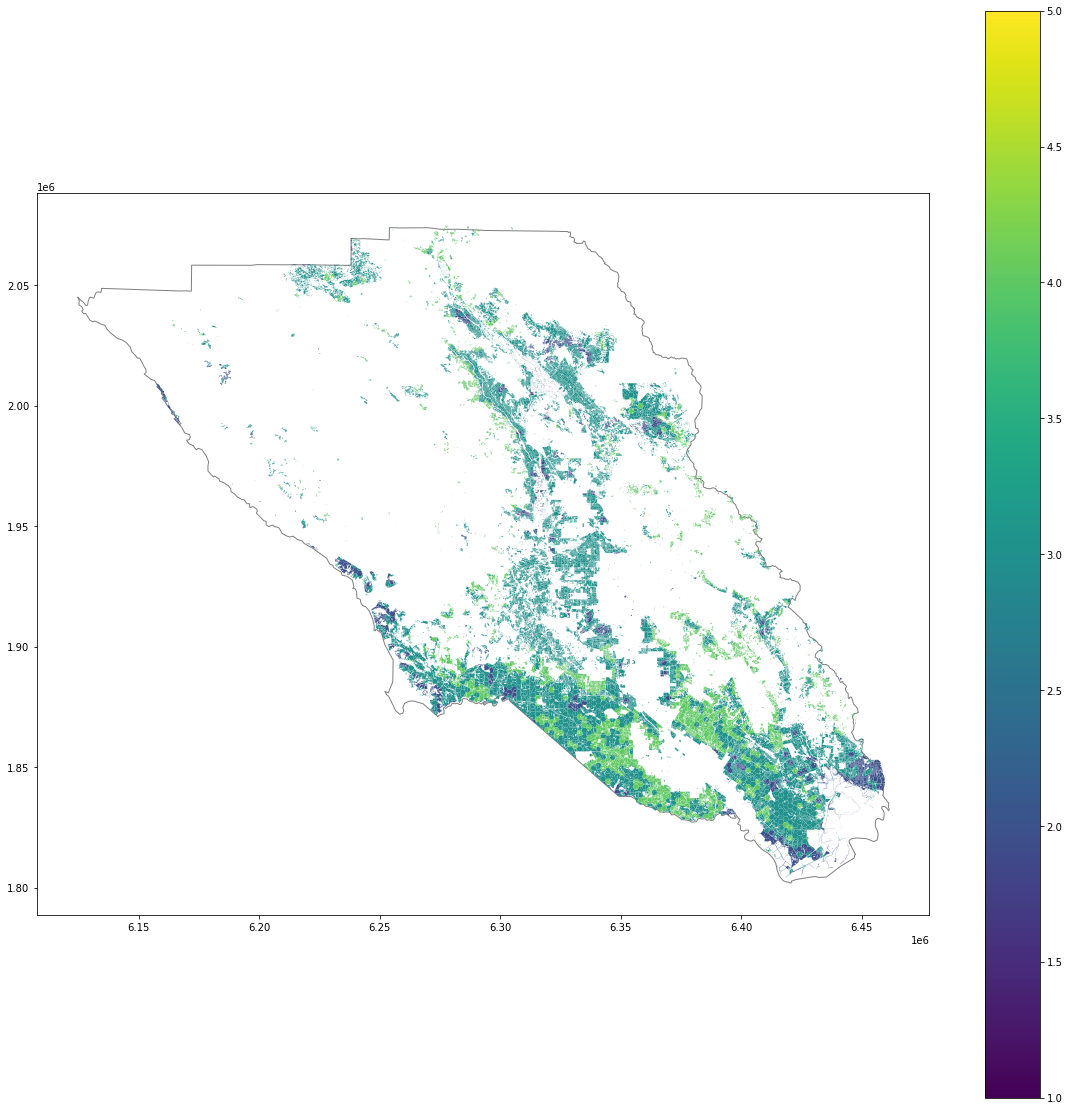

In [33]:
# flooded ag
fig, ax = plt.subplots(figsize=(20,20))
soco_bound.plot(ax=ax, edgecolor = "grey", color = "white")
ag_fire_risk.plot(ax=ax, column = "risk_5_rank", legend = True) 

In [34]:
# save the file
ag_fire_risk.to_file("../data/clean/vulnerability_shps/agriculture/ag_fire_risk.shp") 

C:\Users\AMarley\AppData\Local\Temp\ipykernel_18556\3606252540.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ag_fire_risk.to_file("../data/clean/vulnerability_shps/agriculture/ag_fire_risk.shp")


### Landslide risk